In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [2]:
import sys
# sys.path.append('../')
sys.path.append('../')
sys.path.append('../model')
sys.path.append('../cost')
sys.path.append('../constraints')
import UnicycleModel
import FinaltimeFreeCost
import UnicycleCost
import UnicycleConstraints
from scipy.integrate import solve_ivp
from PTR_tf_free import PTR_tf_free
from PTR_in_MPC import PTR_in_MPC
from Scaling import TrajectoryScaling
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

(CVXPY) Sep 06 07:02:13 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file)")


## Nominal trajectory generation

In [3]:
ix = 3
iu = 2
ih = 2
N = 50
tf = 10
delT = tf/N
max_iter = 30

In [4]:
x_max = np.array([5,5,np.deg2rad(90)])
x_min = np.zeros(ix)

u_max = np.array([2,np.deg2rad(90)]) 
u_min = np.array([0,0])


myScaling = TrajectoryScaling(x_min,x_max,u_min,u_max,tf)
Sx,iSx,sx,Su,iSu,su = myScaling.get_scaling()

In [5]:
myModel = UnicycleModel.unicycle('Hello',ix,iu,'numeric_central')
myCost = FinaltimeFreeCost.Finaltime('Hello',ix,iu,N)
myConst = UnicycleConstraints.UnicycleConstraints('Hello',ix,iu)

In [6]:
xi = np.zeros(3)
xi[0] = -5.0
xi[1] = -5.0 
xi[2] = 0

xf = np.zeros(3)
xf[0] = 5.0
xf[1] = 5.0
xf[2] = 0


x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
    
u0 = np.zeros((N+1,iu))
ui = np.array([2,0])
uf = np.array([2,0])

for i in range(N+1) :
    u0[i] = (N-i)/N * ui + i/N * uf

In [7]:
TrajOpt = PTR_tf_free('unicycle',N,tf,max_iter,myModel,myCost,myConst,myScaling,
          type_discretization="foh",w_c=1,w_vc=1e3,w_tr=1e-1,w_rate=0,tol_vc=1e-6,tol_tr=1e-3)
xfwd,ufwd,xbar,ubar,tfbar,total_num_iter,flag_boundary,l,l_vc,l_tr,x_traj,u_traj,T_traj  = TrajOpt.run(x0,u0,xi,xf)
print("final time {:}".format(tfbar))

iteration   total_cost        cost        ||vc||     ||tr||       reduction   w_tr        dynamics
1           5.696             5.000       1.95e-12    6.96        4.3         0.100       0(0.128)
2           7.734             6.976       3.95e-12    7.57        -2.04       0.100       0(0.0652)
3           7.324             7.132       3.9e-13     1.92        0.409       0.100       0(0.0153)
4           7.256             7.253       1.06e-11    0.0302      0.0685      0.100       1(0.000274)
5           7.252             7.251       8.5e-12     0.0098      0.00348     0.100       1(2.3e-05)
6           7.251             7.250       1.46e-12    0.00635     0.00153     0.100       1(1.8e-05)
7           7.250             7.250       1.01e-12    0.00157     0.000715    0.100       1(3.7e-06)
8           7.250             7.250       8.91e-13    0.00109     0.000236    0.100       1(1.6e-06)
9           7.250             7.250       7.81e-13    0.000881    0.000185    0.100       1(1.31

In [8]:
t_index = np.array([i for i in range(N+1)]) / N * tfbar

In [9]:
tfbar

7.2495603290843835

## Set MPC controller without obstacle

### nominal trajectory is given as xbar, ubar

In [10]:
fun_unom = interp1d(t_index,ubar,axis=0)
def get_traj_teval(t_eval) :
    if len(t_eval) == 0 :
        return [],[]
    assert np.max(t_eval) <= t_index[-1]
    def dfdt(t,x) :
        u = fun_unom(t)
        return np.squeeze(myModel.forward(x,u))

    sol = solve_ivp(dfdt,(t_index[0],t_index[-1]),xi,t_eval=t_eval,rtol=1e-12,atol=1e-12)
    return sol.y.T,fun_unom(t_eval)

def forward_dt(dt,xi,u) :
    def dfdt(t,x) :
        return np.squeeze(myModel.forward(x,u))
    sol = solve_ivp(dfdt,(0,dt),xi,rtol=1e-12,atol=1e-12)
    return sol
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])

In [11]:
tbar = np.array([i for i in range(N+1)]) / N * tfbar
tfsim = 8
horizon = 2
dt = 0.1
Nsim = int(tfsim / dt)
Nmpc =  int(horizon / dt) # N+1 is total discretization points for state
print("Nmpc: {:}".format(Nmpc))

xi_mpc = np.zeros(3)
xi_mpc[0] = -5.0
xi_mpc[1] = -4.0 
xi_mpc[2] = 0

Nmpc: 20


In [12]:
# cost and constraint / model is identical
MPC_Cost = UnicycleCost.unicycleMPC('Hello',ix,iu,Nmpc)
MPC_Const = UnicycleConstraints.unicycleMPC('Hello',ix,iu)

# # define optimal control
MPC_controller = PTR_in_MPC('unicycle',Nmpc,horizon,max_iter,myModel,MPC_Cost,MPC_Const,myScaling,
          type_discretization="zoh",w_c=1,w_vc=1e3,w_bf=1e3,w_tr=1e-1,w_rate=0,
                            tol_vc=1e-6,tol_bf=1e-3,tol_tr=1e-3)

In [15]:
t_curr = 0
x_curr = np.copy(xi_mpc)

t_save,x_save,u_save = [],[],[]
t_save.append(t_curr)
x_save.append(xi_mpc)

t_traj,x_traj,u_traj = [],[],[]
c_traj,H_traj = [],[]


for _ in range(Nsim) :
    print("t curr: {:.2f}  ======================".format(t_curr))
    # estimating nominal trajectory within horizon
    t_horizon = np.array([t_curr + dt*i for i in range(Nmpc+1)])
    t_eval = t_horizon[t_horizon <= tfbar]
    t_end = t_horizon[t_horizon > tfbar]
    xfwd,ufwd = get_traj_teval(t_eval)
    for _ in t_end :
        if len(xfwd) == 0 :
            xfwd = xbar[-1]
            ufwd = ubar[-1]
        else :
            xfwd = np.vstack((xfwd,xbar[-1]))
            ufwd = np.vstack((ufwd,ubar[-1]))


    # estimate the model of non-cooperative agent
    cobs,Hobs = [],[]
    # none obstacle
    for i in range(Nmpc+1) :
        cobs.append(None)
        Hobs.append(None)
        
    
    # solve optimal control
    # initiall condition
    if t_curr == 0 :
        x0 = xfwd
        u0 = ufwd
    else :
        x0 = np.copy(xmpc)
        x0[:Nmpc] = xmpc[1:]
        u0 = np.copy(umpc)
        u0[:Nmpc] = umpc[1:]


    _,_,xmpc,umpc,num_iter,flag_boundary,l,l_vc,l_tr,_,_,_  = MPC_controller.run(x0,u0,x_curr,xfwd,ufwd,cobs,Hobs)

    # apply input to the system (integration)
    sol = forward_dt(dt,x_curr,umpc[0])
    t_curr += dt
    x_curr = sol.y.T[-1]

    # save
    t_save.append(t_curr)
    x_save.append(x_curr)
    u_save.append(umpc[0])

    t_traj.append(t_horizon)
    x_traj.append(xmpc)
    u_traj.append(umpc)
#     break

x_save = np.array(x_save)
u_save = np.array(u_save)

t curr: 0.00  ======================
iteration   total_cost        cost        ||vc||     ||bf||     ||tr||       reduction   w_tr        bounary
1           124.495           123.883     3.22e-10    6.55e-27    6.12        876         0.100       0(0.0302)
2           134.017           133.982     4.07e-10    4.06e-25    0.355       -9.52       0.100       0(0.00112)
3           133.821           133.813     3.77e-11    4.49e-26    0.0828      0.196       0.100       1(0.000326)
4           133.848           133.847     4.88e-11    6.03e-26    0.00689     -0.0266     0.100       1(6.31e-05)
5           133.853           133.853     4.81e-11    2.93e-25    0.00117     -0.00528    0.100       1(7.1e-06)
6           133.854           133.854     5.15e-11    1.18e-25    0.000114    -0.000811   0.100       1(1.24e-06)
SUCCEESS: virtual control and trust region < tol
t curr: 0.10  ======================
1           122.312           122.297     2.01e-10    3.09e-26    0.147       878       

2           69.163            69.163      3.69e-10    2.77e-26    4.61e-05    0.0157      0.100       1(1.09e-08)
SUCCEESS: virtual control and trust region < tol
t curr: 2.50  ======================
1           69.211            69.195      3.6e-10     1.36e-25    0.155       931         0.100       1(1.26e-05)
2           69.195            69.195      3.55e-10    3.93e-25    4.61e-05    0.0157      0.100       1(5.14e-09)
SUCCEESS: virtual control and trust region < tol
t curr: 2.60  ======================
1           69.234            69.219      1.14e-10    3.59e-26    0.155       931         0.100       1(1.32e-05)
2           69.219            69.219      3.42e-10    2.17e-25    4.6e-05     0.0157      0.100       1(1.47e-09)
SUCCEESS: virtual control and trust region < tol
t curr: 2.70  ======================
1           69.252            69.237      1.32e-10    1.71e-26    0.155       931         0.100       1(1.23e-05)
2           69.237            69.237      3.31e-10    5.4e

1           72.155            72.134      5.65e-10    7.42e-25    0.205       928         0.100       0(0.00415)
2           72.151            72.151      2.72e-10    6.26e-26    0.00032     0.00343     0.100       1(3.34e-06)
SUCCEESS: virtual control and trust region < tol
t curr: 5.20  ======================
1           72.837            72.817      5.62e-10    1.62e-25    0.208       927         0.100       0(0.0043)
2           72.835            72.835      1.27e-10    3.97e-26    0.000343    0.00204     0.100       1(3.45e-06)
SUCCEESS: virtual control and trust region < tol
t curr: 5.30  ======================
1           72.353            72.337      5.15e-10    2.42e-25    0.157       928         0.100       0(0.00322)
2           72.353            72.353      5.07e-10    1.67e-25    0.000245    -0.000502   0.100       1(2.25e-06)
SUCCEESS: virtual control and trust region < tol
t curr: 5.40  ======================
1           70.262            70.254      1.52e-10    1.04e-25

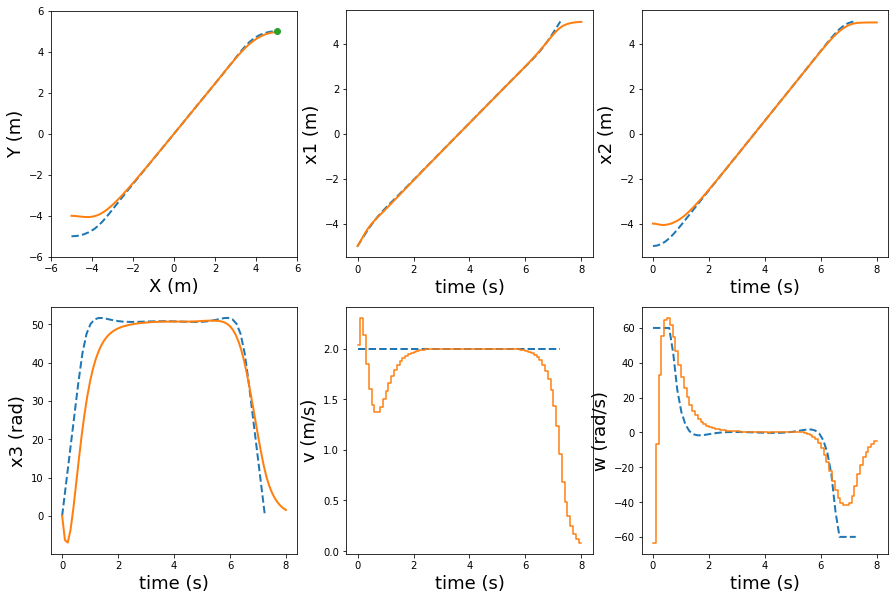

In [16]:
plt.figure(figsize=(15,10))
fS = 18
plt.subplot(231)
plt.plot(xbar[:,0], xbar[:,1],'--', linewidth=2.0)
plt.plot(x_save[:,0], x_save[:,1],'-', linewidth=2.0)
plt.plot(xf[0],xf[1],"o",label='goal')
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([-6, 6, -6, 6])
plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)
plt.subplot(232)
plt.plot(t_index, xbar[:,0],'--', linewidth=2.0)
plt.plot(t_save, x_save[:,0],'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x1 (m)', fontsize = fS)
plt.subplot(233)
plt.plot(t_index, xbar[:,1],'--',linewidth=2.0)
plt.plot(t_save, x_save[:,1],'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x2 (m)', fontsize = fS)
plt.subplot(234)
plt.plot(t_index, np.rad2deg(xbar[:,2]),'--',linewidth=2.0)
plt.plot(t_save, np.rad2deg(x_save[:,2]),'-',linewidth=2.0)
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('x3 (rad)', fontsize = fS)
plt.subplot(235)
plt.plot(t_index, ubar[:,0],'--',linewidth=2.0)
plt.step(t_save,[*u_save[:,0],u_save[-1,0]],label='zoh',where='post')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('v (m/s)', fontsize = fS)
plt.subplot(236)
plt.plot(t_index, np.rad2deg(ubar[:,1]),'--',linewidth=2.0)
plt.step(t_save,np.rad2deg([*u_save[:,1],u_save[-1,1]]),label='zoh',where='post')
plt.xlabel('time (s)', fontsize = fS)
plt.ylabel('w (rad/s)', fontsize = fS)
plt.show()

## make a video

In [17]:
from matplotlib.patches import Rectangle,Ellipse
import imageio
import os

In [19]:
filenames = []
for idx in range(Nsim+1) :
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    fS = 15
    plt.plot(xbar[:,0], xbar[:,1],'--', linewidth=2.0,label='nominal trajectory')
    plt.plot(x_save[:idx+1,0], x_save[:idx+1,1],'-', linewidth=2.0,label='result trajectory')
    if idx < Nsim :
        plt.plot(x_traj[idx][:,0], x_traj[idx][:,1],'-',color='tab:green', linewidth=2.0,label='future prediction')
        plt.plot(x_traj[idx][0,0], x_traj[idx][0,1],'o',color='tab:green', linewidth=2.0)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis([-6, 6, -6, 6])
    plt.xlabel('X (m)', fontsize = fS)
    plt.ylabel('Y (m)', fontsize = fS)
    plt.legend(fontsize=fS)

    filename = '../images/{:d}.png'.format(idx)
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

In [20]:
img_name = 'MPC_without_obstacle'
with imageio.get_writer('../images/'+img_name+'.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
for filename in set(filenames):
    os.remove(filename)

/var/folders/zh/8dk8mcb12vs7vp_rqg6sj_780000gn/T/ipykernel_19275/3364654004.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


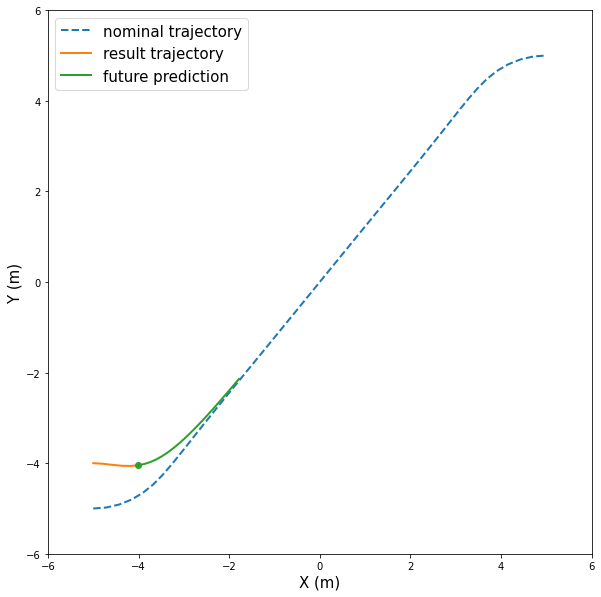

In [23]:
idx = 5
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
fS = 15
plt.plot(xbar[:,0], xbar[:,1],'--', linewidth=2.0,label='nominal trajectory')
plt.plot(x_save[:idx+1,0], x_save[:idx+1,1],'-', linewidth=2.0,label='result trajectory')
if idx < Nsim :
    plt.plot(x_traj[idx][:,0], x_traj[idx][:,1],'-',color='tab:green', linewidth=2.0,label='future prediction')
    plt.plot(x_traj[idx][0,0], x_traj[idx][0,1],'o',color='tab:green', linewidth=2.0)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis([-6, 6, -6, 6])
plt.xlabel('X (m)', fontsize = fS)
plt.ylabel('Y (m)', fontsize = fS)
plt.legend(fontsize=fS)